# VARIMA (Vector Autoregressive integrated moving average)

https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

In [117]:
import pandas as pd
import openpyxl 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, grangercausalitytests


In [66]:
df = pd.read_csv('../datasets/temperature.csv')
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [67]:
# fecha en solo una columna
def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s, "%Y-%m-%d")

In [68]:
df['Date'] = df.apply(parse_date, axis=1)

In [69]:
#D = 2 
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [70]:
# solo las columnas necesarias
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [71]:
# index Date
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']



In [72]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [73]:
#Lo mismo para la otra ciudad
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']

In [74]:
#Unir los 2 df
joined = auckland.join(stockholm, how='outer') # has some missing data


In [75]:
joined.shape


(3155, 2)

In [76]:
#Solo 500 renglones
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [77]:
joined_part.isna().sum()


AucklandTemp     1
StockholmTemp    4
dtype: int64

In [78]:
joined_part.interpolate(inplace=True)


In [79]:
joined_part.isna().sum() 

AucklandTemp     0
StockholmTemp    0
dtype: int64

<Axes: xlabel='Date'>

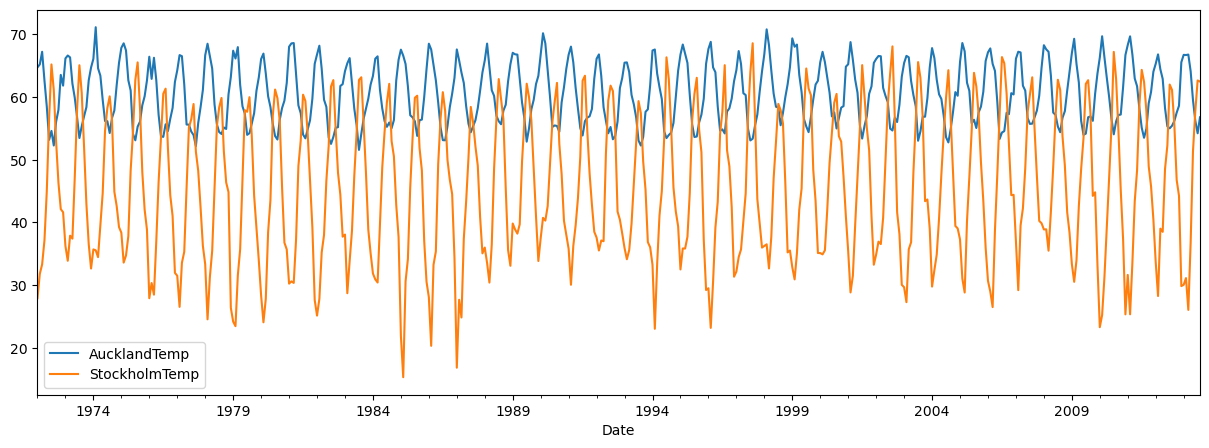

In [80]:
joined_part.plot(figsize=(15, 5))

In [81]:
#split
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [82]:
#Escalar
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [83]:
#Escalar
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])

In [84]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [85]:
# original df
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']


<Axes: xlabel='Date'>

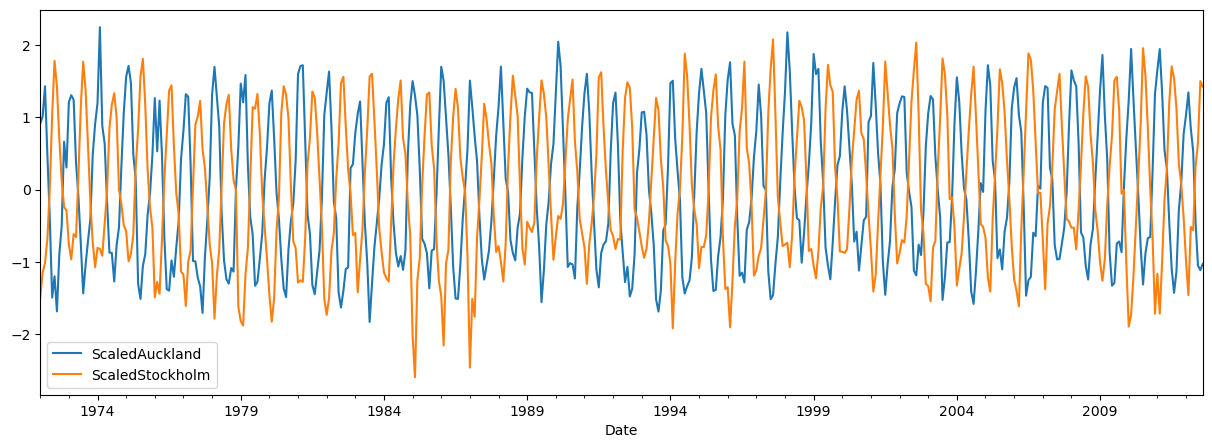

In [86]:
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot(figsize=(15, 5)) #misma escala

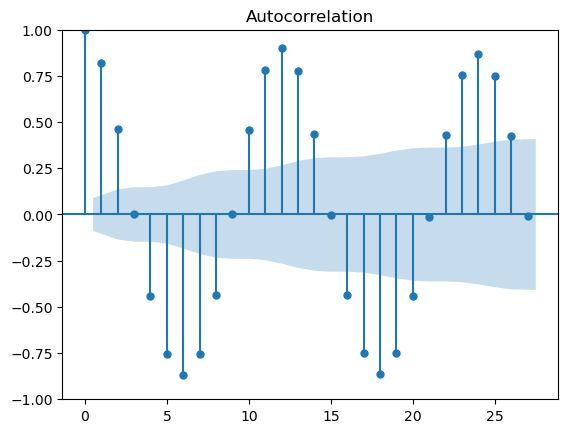

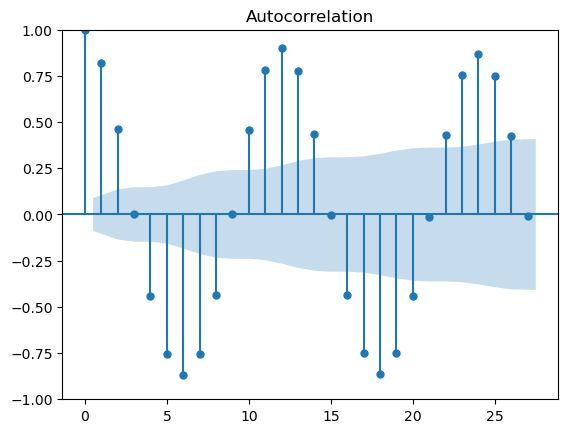

In [87]:
plot_acf(train['ScaledAuckland']) #patrón de estacionalidad


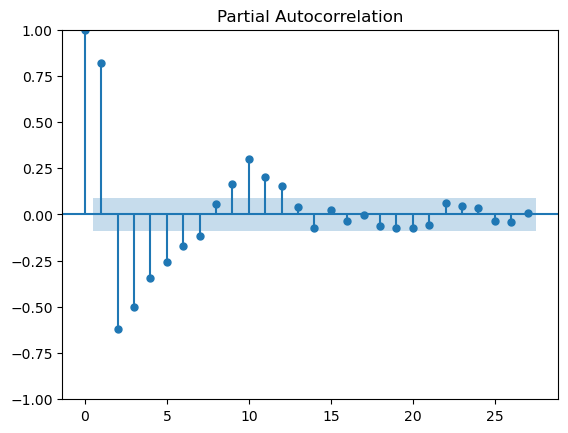

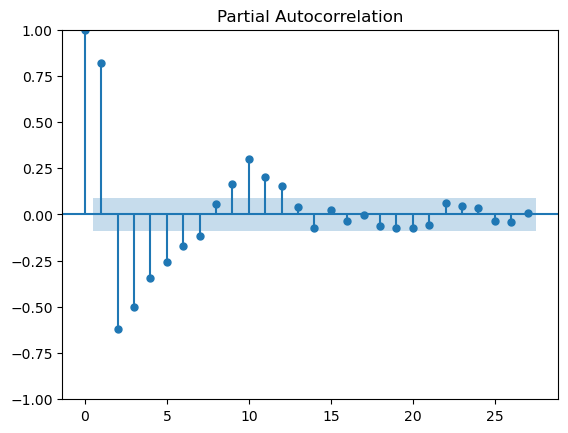

In [88]:
plot_pacf(train['ScaledAuckland']) #cerca de cero mayor significancia


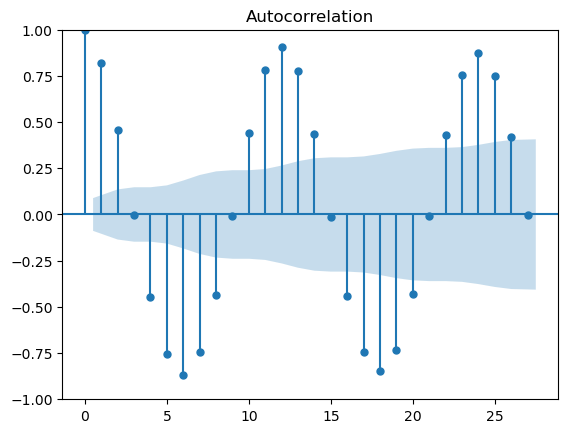

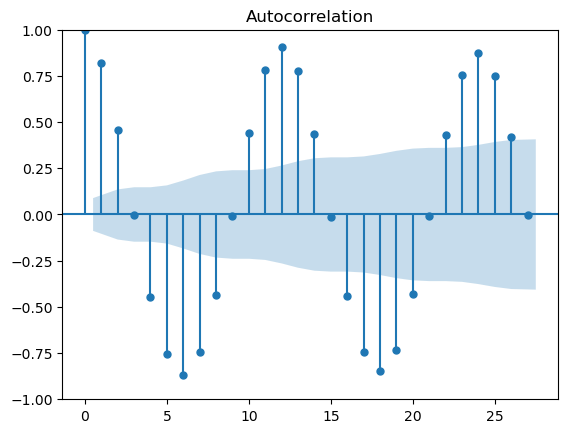

In [89]:
plot_acf(train['ScaledStockholm'])


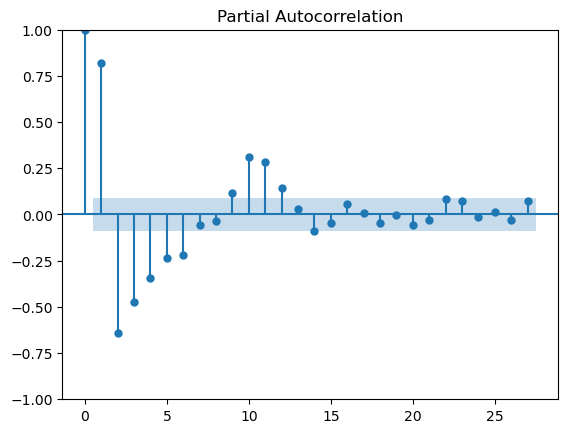

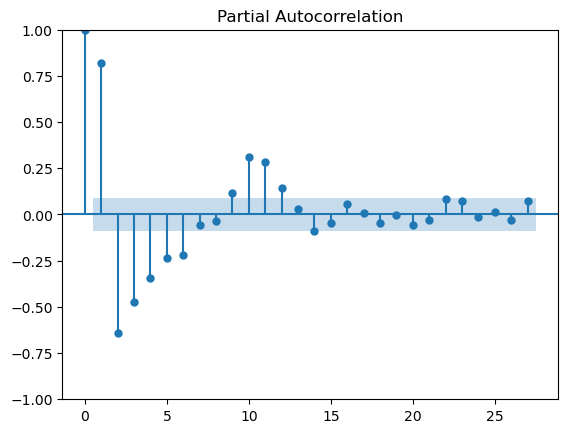

In [90]:
plot_pacf(train['ScaledStockholm'])


In [91]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10)) #prueba otros valores
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0) #warning: solucion no unica


/home/isadoji/.conda/envs/py3/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           85     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88166D-01    |proj g|=  4.98695D-01


 This problem is unconstrained.



At iterate    5    f=  2.74661D-01    |proj g|=  1.76113D-01

At iterate   10    f=  2.57041D-01    |proj g|=  1.21188D-01

At iterate   15    f=  2.43906D-01    |proj g|=  1.86507D-01

At iterate   20    f=  2.28385D-01    |proj g|=  1.44935D-01

At iterate   25    f=  2.16511D-01    |proj g|=  4.70634D-02

At iterate   30    f=  2.12106D-01    |proj g|=  7.70679D-02

At iterate   35    f=  2.06768D-01    |proj g|=  1.98933D-01

At iterate   40    f=  2.05101D-01    |proj g|=  2.68162D-01

At iterate   45    f=  2.03225D-01    |proj g|=  1.48565D-01

At iterate   50    f=  2.01827D-01    |proj g|=  6.11597D-02

At iterate   55    f=  1.99231D-01    |proj g|=  1.02488D-01

At iterate   60    f=  1.96451D-01    |proj g|=  1.50936D-01

At iterate   65    f=  1.94604D-01    |proj g|=  6.33928D-02

At iterate   70    f=  1.92005D-01    |proj g|=  3.43108D-01

At iterate   75    f=  1.89856D-01    |proj g|=  1.39523D-01

At iterate   80    f=  1.85053D-01    |proj g|=  1.05075D-01

At iter

/home/isadoji/.conda/envs/py3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:04:04.017045


In [92]:
#Forcast
fcast = res.get_forecast(Ntest)
# fcast.conf_int() # ejemplo intervalao de confianza


In [93]:
res.fittedvalues['ScaledAuckland'] #regresa la serie


Date
1972-01-01    0.004221
1972-02-01    0.832480
1972-03-01    0.727547
1972-04-01    0.823049
1972-05-01   -0.078784
                ...   
2012-04-01    0.522403
2012-05-01   -0.291082
2012-06-01   -1.060810
2012-07-01   -1.335628
2012-08-01   -1.053474
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [94]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland'] #asignar valores fit
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland'] #asignar predict valores

<Axes: xlabel='Date'>

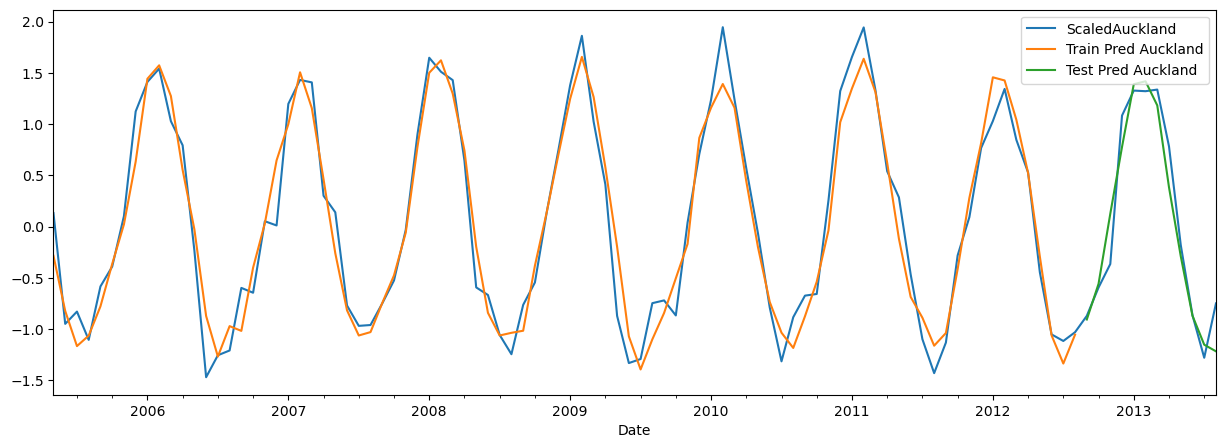

In [95]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))

In [96]:
#La otra ciudad
joined_part.loc[train_idx, 'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

<Axes: xlabel='Date'>

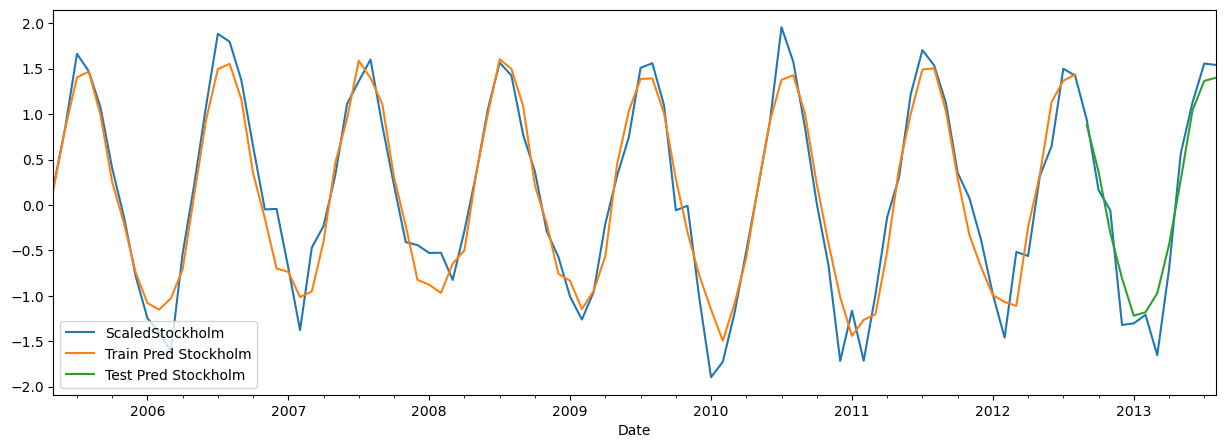

In [97]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))

In [98]:
# R2
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.9294854537162656
Auckland Test R^2: 0.9305586805699803


In [99]:
#R2
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Train R^2:", r2_score(y_true, y_pred))


y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9247679712644495
Stockholm Test R^2: 0.9311734957276059


## VAR

In [100]:
model = VAR(train[cols]) #objetopara VAR

In [101]:
lag_order_results = model.select_order(maxlags=15) #prueba,probar otros valores
lag_order_results

In [102]:
lag_order_results.selected_orders # atributos

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [103]:
#Fit
results = model.fit(maxlags=15, ic='aic') # No. pasos

In [104]:
lag_order = results.k_ar #inicio

In [105]:
prior = train.iloc[-lag_order:][cols].to_numpy() # numpy ->vector
fcast = results.forecast(prior, Ntest)

<Axes: xlabel='Date'>

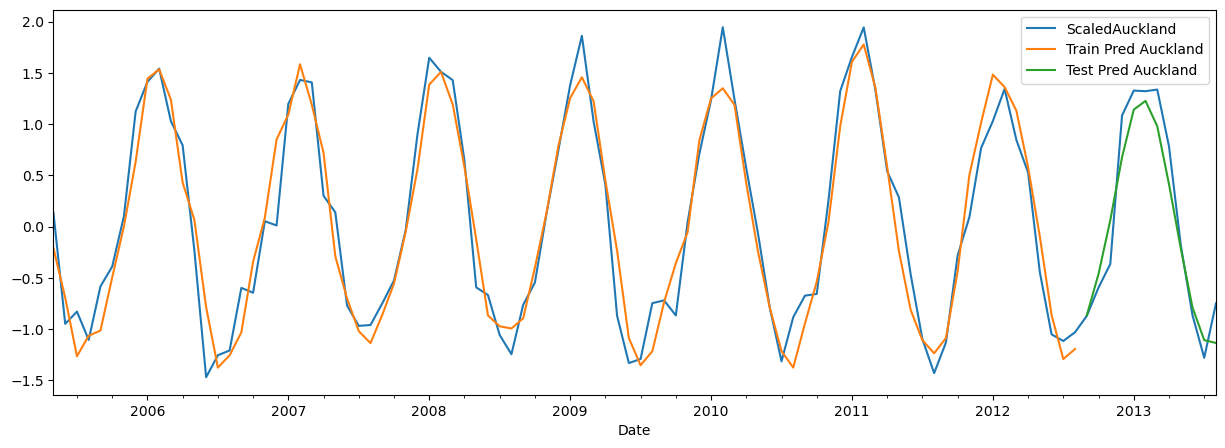

In [106]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast[:,0]

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))


<Axes: xlabel='Date'>

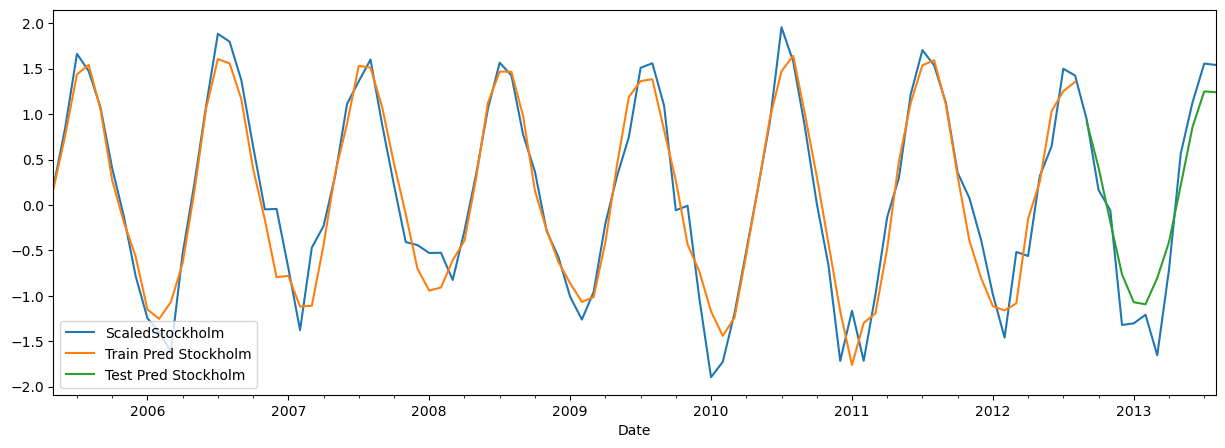

In [107]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))

In [108]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340895


In [109]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']

Stockholm Train R^2: 0.9267030553588321


## ARIMA (comparación)

In [111]:
for col in cols:
  model = ARIMA(train[col], order=(10, 0, 10))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

/home/isadoji/.conda/envs/py3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213763853929039
ScaledAuckland Test R^2: 0.9380758152044916
ScaledStockholm Train R^2: 0.9207375271733982
ScaledStockholm Test R^2: 0.9482201717425722


/home/isadoji/.conda/envs/py3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mejor predicción. Que pasa con SARIMA?

## Prueba de Granger

Datos trimestrales sobre el PIB real de Estados Unidos desde 1957 hasta 2013.

https://www.princeton.edu/~mwatson/Stock-Watson_3u/Students/EE_Datasets/us_macro_quarterly.xlsx

Análisis de los datos: https://econoalgoritmia.jeshuanomics.com/15-2-DSTCS.html


In [120]:
df = pd.read_excel('../datasets/us_macro_quarterly.xlsx')
df

/home/isadoji/.conda/envs/py3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667
...,...,...,...,...,...,...,...,...,...,...
223,2012:04,15539.628,94.258812,106.622,1.706667,0.173333,0.086667,7.833333,1.606433,231.277000
224,2013:01,15583.948,94.725440,106.909,1.950000,0.153333,0.086667,7.700000,1.550633,232.102667
225,2013:02,15679.677,95.992001,106.878,1.996667,0.126667,0.050000,7.500000,1.536700,232.086667
226,2013:03,15839.347,97.558537,107.387,2.710000,0.123333,0.033333,7.233333,1.552300,233.597000


In [121]:
def parse_date(data):
  # quarter is in {01,02,03,04}
  year, quarter = data.split(':')
  month = (int(quarter) - 1) * 3 + 1
  s = f"{year}-{month}"
  return datetime.strptime(s, "%Y-%m")

In [123]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)


In [124]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


<Axes: >

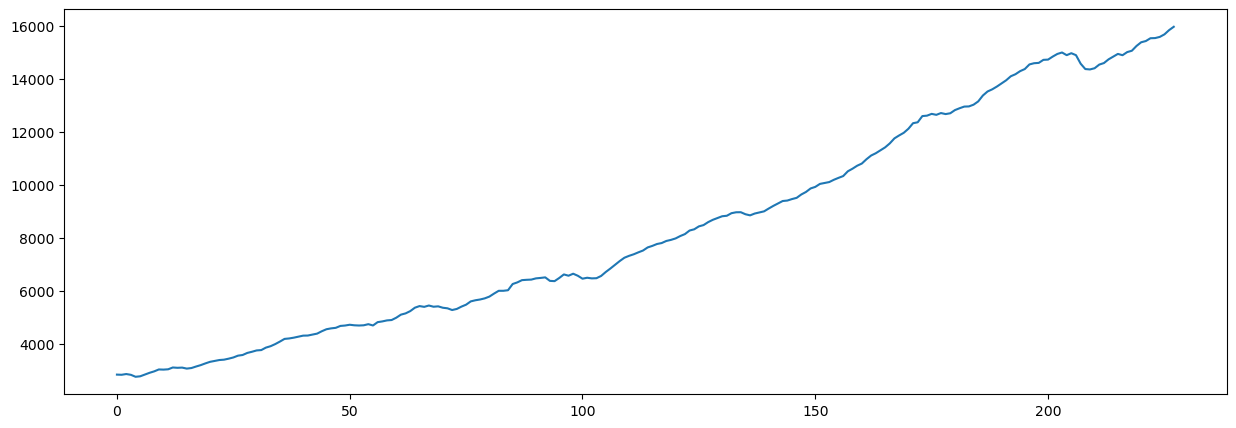

In [125]:
# GDP
df['GDPC96'].plot(figsize=(15, 5))

In [126]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()

In [127]:
df['TSpread'] = df['GS10'] - df['TB3MS']

<Axes: >

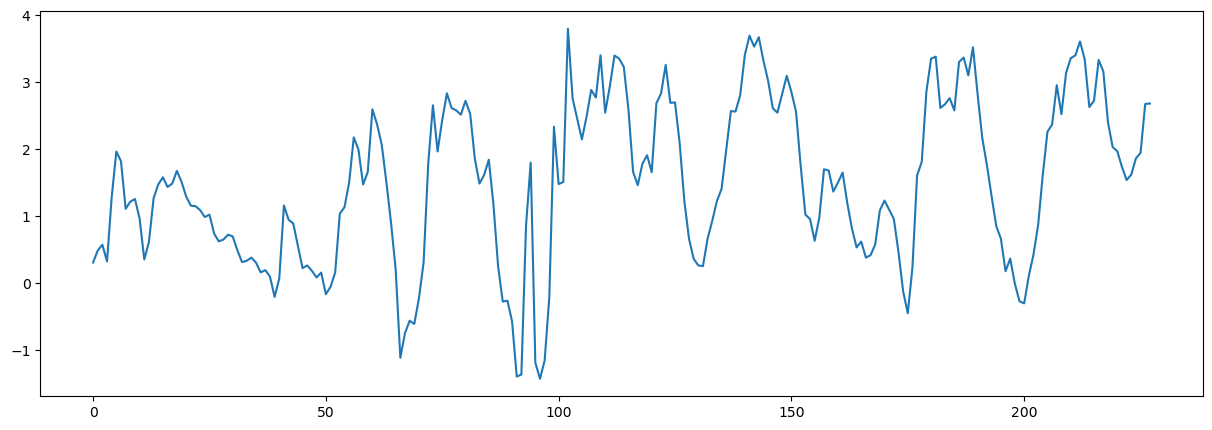

In [128]:
df['TSpread'].plot(figsize=(15, 5))

In [129]:
cols = ['GDPGrowth', 'TSpread']

## Granger

In [131]:
df1 = df.iloc[1:][cols].copy() 

In [132]:
granger_result = grangercausalitytests(df1, maxlag=18)#2 afecta 1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=6.2612  , p=0.0123  , df=1
likelihood ratio test: chi2=6.1761  , p=0.0129  , df=1
parameter F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2
ssr based chi2 test:   chi2=10.0555 , p=0.0066  , df=2
likelihood ratio test: chi2=9.8373  , p=0.0073  , df=2
parameter F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3
ssr based chi2 test:   chi2=10.6710 , p=0.0136  , df=3
likelihood ratio test: chi2=10.4246 , p=0.0153  , df=3
parameter F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8964  , p=0.0230  

In [133]:
granger_result = grangercausalitytests(df1[reversed(cols)], maxlag=18)#2 afecta 1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9872 , p=0.0006  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=12.1485 , p=0.0005  , df=1
likelihood ratio test: chi2=11.8332 , p=0.0006  , df=1
parameter F test:         F=11.9872 , p=0.0006  , df_denom=223, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4010  , p=0.0051  , df_denom=220, df_num=2
ssr based chi2 test:   chi2=11.0476 , p=0.0040  , df=2
likelihood ratio test: chi2=10.7849 , p=0.0046  , df=2
parameter F test:         F=5.4010  , p=0.0051  , df_denom=220, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8793  , p=0.0026  , df_denom=217, df_num=3
ssr based chi2 test:   chi2=15.1100 , p=0.0017  , df=3
likelihood ratio test: chi2=14.6221 , p=0.0022  , df=3
parameter F test:         F=4.8793  , p=0.0026  , df_denom=217, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1513  , p=0.0152  